___
# Valuation of Employee Stock Options

___
## Quick and Dirty approach using the BSM 

Example 16.1

In [81]:
# A company grants 1,000,000 options to its executives on November 1, 2014. The
# stock price on that date is $30 and the strike price of the options is also $30. The
# options last for 10 years and vest after three years. The company has issued
# similar at-the-money options for the last 10 years. The average time to exercise
# or expiry of these options is 4.5 years. The company therefore decides to use an
# ‘‘expected life’’ of 4.5 years. It estimates the long-term volatility of the stock
# price, using 5 years of historical data, to be 25%. The present value of dividends
# during the next 4.5 years is estimated to be $4. The 4.5-year zero-coupon risk-free
# interest rate is 5%. The option is therefore valued using the Black–Scholes–
# Merton model
import datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from scipy.stats import norm

num_options = 1_000_000
grant_date = datetime.date(2014, 11, 1)

S0 = 30
K = 30
vol = 0.25
q = 4
r = 0.05

T = 10
maturity_date = grant_date + relativedelta(years=T)
vesting_date = grant_date + relativedelta(years=3)
avg_T = 4.5


def bsm_call(S0, K, vol, q, r, T):

    S0 -= q  # * np.exp(-r * T)

    d1 = (np.log(S0 / K) + (r + vol**2 / 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)

    call_value = norm.cdf(d1) * S0 - norm.cdf(d2) * K * np.exp(-r * T)

    return call_value


call_pv = bsm_call(S0, K, vol, q, r, avg_T)

esop_value = num_options * call_pv

print(f"ESOP value is {esop_value}")

ESOP value is 6306219.752478945


___
## Binomial Tree

In [138]:
class CoxRossRubinstein:
    """Represents a Cox, Ross & Rubinstein binomial tree."""

    def __init__(
        self, S0, K, sigma, r, T, steps, option_type="call", exercise_type="european"
    ):
        self.S0 = S0
        self.K = K
        self.sigma = sigma
        self.r = r
        self.T = T
        self.M = steps
        self.dt = self.T / self.M

        self.option_type = option_type
        self.exercise_type = exercise_type

        self._calculate_movements()

    def _calculate_movements(self):
        """
        Calculates the up & down movement size using the volatility and time step.
        Also calculates the probability of the up movement.

        Returns
        -------
            None
        """
        self.u = np.exp(self.sigma * np.sqrt(self.dt))
        self.d = 1 / self.u
        self.p = (np.exp(self.r * self.dt) - self.d) / (self.u - self.d)

    def _overwrite_movements(self, u, d):
        self.u = u
        self.d = d
        self.p = (np.exp(self.r * self.dt) - self.d) / (self.u - self.d)

    def simulate_price_tree(self):
        """
        Function to generate the tree of stock prices

        Returns
        -------
        np.ndarray
            the triangular matrix (upper) for of the price tree.
        """
        dt = self.T / self.M
        up = np.arange(self.M + 1)
        up = np.resize(up, (self.M + 1, self.M + 1))
        down = up.transpose() * 2
        S = self.S0 * np.exp(self.sigma * np.sqrt(dt) * (up - down))
        return np.triu(S)

    def simulate_price_tree_iter(self, u, d):

        # interval
        dt = self.T / self.M

        # movements. If u is not passed as argument it will be calculated
        if u is None:
            u = np.exp(self.sigma * np.sqrt(dt))
        # same with d
        if d is None:
            u = np.exp(-self.sigma * np.sqrt(dt))

        # vector of prices, first price is our starting point
        S = np.zeros((self.M + 1, self.M + 1))
        S[0, 0] = self.S0

        z = 1
        for t in range(1, self.M + 1):
            for i in range(z):
                S[i, t] = S[i, t - 1] * u
                S[i + 1, t] = S[i, t - 1] * d
            z += 1
        return S

    def calculate_payoffs(self, price_tree):
        """
        Function to calculate call option payoff at every node.
        Payoff is calculated as the excess of the stock price over the strike price.

        Returns
        -------
        np.ndarray
            the payoff matrix.
        """
        if self.option_type == "call":
            payoffs = np.maximum(np.triu(price_tree - self.K), 0)
        else:
            payoffs = np.maximum(np.triu(self.K - price_tree), 0)
        return payoffs

    def _grab_up(self, matrix, i, j):
        """
        Returns the up movement value from the position of [i, j].
        `i` represents the row of the matrix, `j` is the column.

        Returns
        -------
        np.float64
            the up movement value.
        """
        up_i = i
        up_j = j + 1
        return matrix[up_i, up_j]

    def _grab_down(self, matrix, i, j):
        """
        Returns the down movement value from the position of [i, j].
        `i` represents the row of the matrix, `j` is the column.

        Returns
        -------
        np.float64
            the up down value.
        """
        down_i = i + 1
        down_j = j + 1
        return matrix[down_i, down_j]

    def calculate_option_values(self, payoffs):
        """
        Calculates the option's fair value at every node of the tree.
        `i` represents the row of the matrix, `j` is the column.

        Parameters
        -------
        payoffs : np.ndarray
            the payoff matrix

        Returns
        -------
        np.ndarray
            matrix representing fair value of the option at every tree node.
        """

        # initialize result object
        result = np.zeros_like(payoffs)
        # for the last column, fair value is equal to the payoff (terminal node)
        result[:, -1] = payoffs[:, -1]

        range_cols = reversed(range(len(payoffs) - 1))
        range_rows = range(len(payoffs) - 1)

        for j in range_cols:
            for i in range_rows:

                # print(f"{i=} | {j=}")

                # for the second to last column we want payoffs
                # because the value of the option will be the payoff
                # at the terminal node
                if j == len(payoffs) - 1:
                    source = payoffs
                # for other columns just take the calculated option value
                else:
                    source = result

                up_poff = self._grab_up(source, i, j)
                down_poff = self._grab_down(source, i, j)

                # print(f"{up_poff=} | {down_poff=}")

                discounted_weighted_payoff_i_j = np.exp(-self.r * self.dt) * (
                    self.p * up_poff + (1 - self.p) * down_poff
                )

                # print(f"{self.p=}")
                # print(f"{discounted_weighted_payoff_i_j=}")

                if self.exercise_type == "american":
                    result[i, j] = max(payoffs[i, j], discounted_weighted_payoff_i_j)
                else:
                    result[i, j] = discounted_weighted_payoff_i_j

        return np.triu(result)

    def present_value(self, verbosity=0):
        """
        Returns the present value of the option.

        Returns
        -------
        np.float64
            present value of the option.
        """
        self.price_tree = self.simulate_price_tree()
        self.payoffs = self.calculate_payoffs(self.price_tree)
        self.values = self.calculate_option_values(self.payoffs)

        self.pv = self.values[0, 0]

        if verbosity:
            with np.printoptions(
                linewidth=np.inf, threshold=np.inf, suppress=True, precision=4
            ):
                scaler = 69
                print("Price tree")
                print("-" * scaler)
                print(self.price_tree)
                print()
                print("Payoffs")
                print("-" * scaler)
                print(self.payoffs)
                print()
                print("Option values")
                print("-" * scaler)
                print(self.values)
                print()
                print("=" * 20, f" Present value of the option is {self.pv.round(2)}")

        return self.pv

**<span style="color:#96d4c5">European call</span>**


In [125]:
crr = CoxRossRubinstein(40, 40, 0.3, 0.05, 8, 4)
price_tree = crr.simulate_price_tree()
payoffs = crr.calculate_payoffs(price_tree)
values = crr.calculate_option_values(payoffs)

print(price_tree)
print()
print(payoffs)
print()
print(values)

[[ 40.          61.13860641  93.44822985 142.83236362 218.31429157]
 [  0.          26.17004367  40.          61.13860641  93.44822985]
 [  0.           0.          17.12177965  26.17004367  40.        ]
 [  0.           0.           0.          11.20194303  17.12177965]
 [  0.           0.           0.           0.           7.32888346]]

[[  0.          21.13860641  53.44822985 102.83236362 178.31429157]
 [  0.           0.           0.          21.13860641  53.44822985]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]]

[[ 17.98283315  33.42988882  60.69899973 106.6388669  178.31429157]
 [  0.           5.43362423  11.64226578  24.94510969  53.44822985]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0

**<span style="color:#96d4c5">European put</span>**

In [117]:
crr = CoxRossRubinstein(
    50, 52, 0.186, 0.05, 2, 2, option_type="put", exercise_type="european"
)

price_tree = crr.simulate_price_tree_iter(u=1.2, d=0.8)
crr._overwrite_movements(1.2, 0.8)
payoffs = crr.calculate_payoffs(price_tree)
values = crr.calculate_option_values(payoffs)

print(price_tree)
print()
print(payoffs)
print()
print(values)

[[50. 60. 72.]
 [ 0. 40. 48.]
 [ 0.  0. 32.]]

[[ 2.  0.  0.]
 [ 0. 12.  4.]
 [ 0.  0. 20.]]

[[ 4.19265428  1.41475309  0.        ]
 [ 0.          9.46393007  4.        ]
 [ 0.          0.         20.        ]]


**<span style="color:#96d4c5">American put</span>**

In [118]:
crr = CoxRossRubinstein(
    50, 52, 0.186, 0.05, 2, 2, option_type="put", exercise_type="american"
)

price_tree = crr.simulate_price_tree_iter(u=1.2, d=0.8)
crr._overwrite_movements(1.2, 0.8)
payoffs = crr.calculate_payoffs(price_tree)
values = crr.calculate_option_values(payoffs)

print(price_tree)
print()
print(payoffs)
print()
print(values)

[[50. 60. 72.]
 [ 0. 40. 48.]
 [ 0.  0. 32.]]

[[ 2.  0.  0.]
 [ 0. 12.  4.]
 [ 0.  0. 20.]]

[[ 5.08963247  1.41475309  0.        ]
 [ 0.         12.          4.        ]
 [ 0.          0.         20.        ]]


**<span style="color:#96d4c5">American call</span>**

In [126]:
crr = CoxRossRubinstein(
    40, 40, 0.3, 0.05, 8, 4, option_type="call", exercise_type="american"
)

price_tree = crr.simulate_price_tree()
payoffs = crr.calculate_payoffs(price_tree)
values = crr.calculate_option_values(payoffs)

print(price_tree)
print()
print(payoffs)
print()
print(values)

[[ 40.          61.13860641  93.44822985 142.83236362 218.31429157]
 [  0.          26.17004367  40.          61.13860641  93.44822985]
 [  0.           0.          17.12177965  26.17004367  40.        ]
 [  0.           0.           0.          11.20194303  17.12177965]
 [  0.           0.           0.           0.           7.32888346]]

[[  0.          21.13860641  53.44822985 102.83236362 178.31429157]
 [  0.           0.           0.          21.13860641  53.44822985]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]]

[[ 17.98283315  33.42988882  60.69899973 106.6388669  178.31429157]
 [  0.           5.43362423  11.64226578  24.94510969  53.44822985]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0

In [139]:
crr = CoxRossRubinstein(
    40, 40, 0.3, 0.05, 8, 20, option_type="call", exercise_type="american"
)

crr.present_value(verbosity=1)

Price tree
---------------------------------------------------------------------
[[  40.       48.3572   58.4606   70.6748   85.441   103.2923  124.8733  150.9632  182.5041  220.6349  266.7324  322.4612  389.8334  471.2817  569.7472  688.7851  832.6938 1006.6695 1216.9942 1471.2623 1778.6548]
 [   0.       33.0871   40.       48.3572   58.4606   70.6748   85.441   103.2923  124.8733  150.9632  182.5041  220.6349  266.7324  322.4612  389.8334  471.2817  569.7472  688.7851  832.6938 1006.6695 1216.9942]
 [   0.        0.       27.3689   33.0871   40.       48.3572   58.4606   70.6748   85.441   103.2923  124.8733  150.9632  182.5041  220.6349  266.7324  322.4612  389.8334  471.2817  569.7472  688.7851  832.6938]
 [   0.        0.        0.       22.6389   27.3689   33.0871   40.       48.3572   58.4606   70.6748   85.441   103.2923  124.8733  150.9632  182.5041  220.6349  266.7324  322.4612  389.8334  471.2817  569.7472]
 [   0.        0.        0.        0.       18.7264   22.6389   27.

18.53656225561678

___
## Visualization

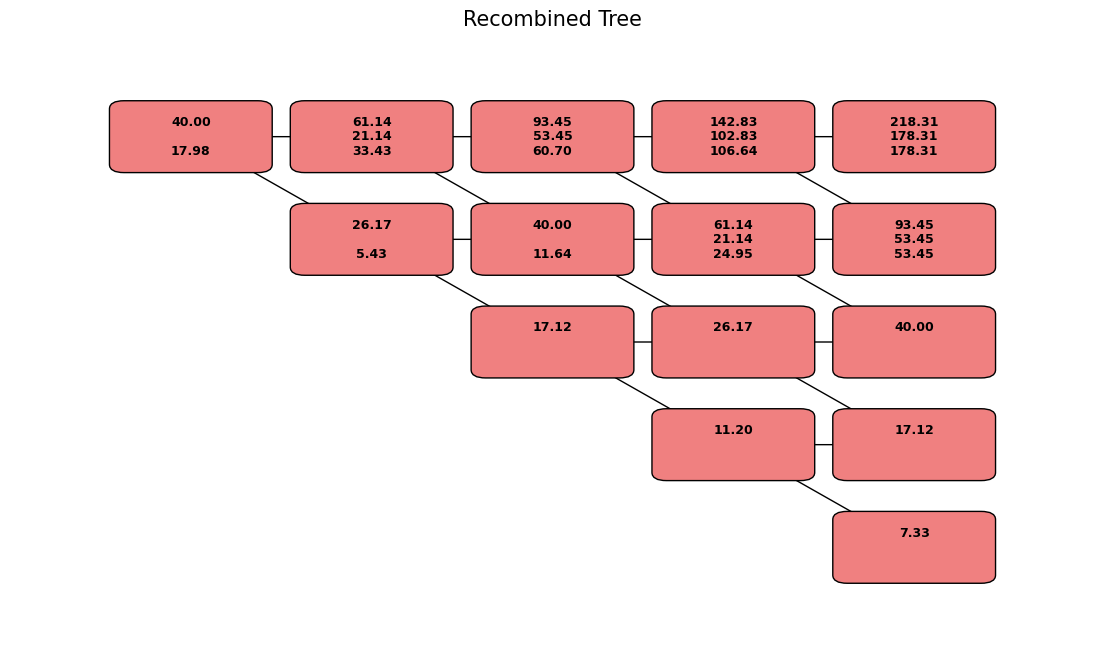

In [84]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx
import numpy as np

# ---- 1.  Put your three matrices here ----------------------------------
A = price_tree
B = payoffs
C = values
# ------------------------------------------------------------------------

mats = [A, B, C]  # put them in a list for convenience
rows, cols = A.shape

# ---- 2.  Build the graph (same rule: right child & diag-down child) ----
G = nx.DiGraph()
for i in range(rows):
    for j in range(cols):
        # keep the node if ANY matrix has a non-zero value there
        if any(M[i, j] != 0 for M in mats):
            node = (i, j)
            G.add_node(node)

            # right child (i, j+1)
            if j + 1 < cols and any(M[i, j + 1] != 0 for M in mats):
                G.add_edge(node, (i, j + 1))

            # diag-down child (i+1, j+1)
            if (
                i + 1 < rows
                and j + 1 < cols
                and any(M[i + 1, j + 1] != 0 for M in mats)
            ):
                G.add_edge(node, (i + 1, j + 1))

# ---- 3.  Layout positions ------------------------------------------------
pos = {(i, j): (j, -i) for (i, j) in G.nodes()}


# ---- 4.  Prepare multiline labels ---------------------------------------
def label_for(i, j):
    lines = []
    for M in mats:
        v = M[i, j]
        lines.append("" if v == 0 else f"{v:.2f}")
    return "\n".join(lines)


labels = {(i, j): label_for(i, j) for (i, j) in G.nodes()}

# ---- 5.  Draw ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 8))

# edges
nx.draw_networkx_edges(G, pos, ax=ax, arrows=True, arrowstyle="->")

# rectangles
w, h = 0.8, 0.6  # rectangle width & height
for (i, j), (x, y) in pos.items():
    rect = patches.FancyBboxPatch(
        (x - w / 2, y - h / 2),
        w,
        h,
        boxstyle="round,pad=0.05,rounding_size=0.08",
        facecolor="lightcoral",
        edgecolor="black",
    )
    ax.add_patch(rect)
    ax.text(
        x,
        y,
        labels[(i, j)],
        ha="center",
        va="center",
        fontsize=9,
        fontweight="bold",
        linespacing=1.15,
    )

ax.set_xlim(min(x for x, y in pos.values()) - 1, max(x for x, y in pos.values()) + 1)
ax.set_ylim(min(y for x, y in pos.values()) - 1, max(y for x, y in pos.values()) + 1)
ax.set_title("Recombined Tree", fontsize=15)
ax.axis("off")
plt.show()